<div align="right" style="text-align: right"><i>Peter Norvig<br>August 2021</i></div>

# RaceTrack

From 538's [The Riddler](https://fivethirtyeight.com/features/can-you-zoom-around-the-race-track/) on 6 August 2021:

> The game of [RaceTrack](https://link.springer.com/chapter/10.1007/978-3-642-13122-6_26) was published by recreational mathematician Martin Gardner in 1973. There have been a few modifications and even some neat [digital versions](https://harmmade.com/vectorracer/#) since then, and it’s high time we had a race here on The Riddler. So without further ado, welcome to the Riddler-opolis 500!
>
> You begin at the midpoint of the starting line at the bottom (the thicker border), and your goal is to circumnavigate the race track shown below in a single counterclockwise loop. You’ll be moving from point to point on the grid, without ever venturing into the gray surrounding square or the central circle. If the center is at the origin (with radius 3), the starting point in blue is at (0, -5). The starting line is between (0, -3) and (0, -7).
>
> For your first move, you can choose among nine grid points surrounding and including the starting position. From there,  you have inertia. So for your second move, you again have nine possible destinations, but they are determined by your current velocity vector. That is, you can maintain your current direction and speed, or you can alter your destination by one point in any direction (horizontally, vertically or diagonally). For example, if your first move was up and to the right, then your possible second moves are shown below, although two of them will cause you to crash into the wall.
>
> ![](https://fivethirtyeight.com/wp-content/uploads/2021/08/Screen-Shot-2021-08-04-at-10.44.11-PM.png?w=400)
>
> How quickly can you navigate the track? At no time can your path venture into the wall. (Being tangent to the wall is allowed, as is being on a grid point along a wall.)
>


# Defining Points and the Track

First some imports: 

In [1]:
import matplotlib.pyplot as plt
from typing import List, Tuple, Iterator
import math

Now define a `Point` in the 2-D plane as a complex number (with functions to extract the `X` and `Y` components), and a `Path` as a list of points. Then define some global variables: the points in the `track`;  the `finish` line; the `start` point; the `zero` vector; and the allowable `deltas` (the nine possible changes on each move).

In [2]:
Point = Vector = complex
Path  = List[Point]
def X(point) -> float: return point.real
def Y(point) -> float: return point.imag

track  = {Point(x, y) for x in range(-7, 8) for y in range(-7, 8) if abs(Point(x, y)) >= 3}
finish = [Point(0, -3), Point(0, -7)]
start  = sum(finish) / 2 # midpoint of finish line
zero   = Vector(0, 0)
deltas = [Vector(x, y) for y in (1, 0, -1) for x in (-1, 0, 1) ]

# Visualization

I think it will be helpful to introduce a way to visualize the track and the path(s) on it:

In [3]:
def plot(paths=(), track=track, start=start, finish=finish):
    """Plot the track and any paths, along with the start and finish line."""
    fig, ax = plt.subplots()
    plt.xticks([]); plt.yticks([])
    ax.set_aspect('equal');
    ax.add_artist(plt.Circle((0, 0), 3, alpha=0.1, color='k', ec='w'))
    ax.plot(*XY(track), 'k,' )   # grid points
    for path in paths:
        ax.plot(*XY(path), 'o-') # paths
    ax.plot(*XY([start]), 'bD')  # start
    ax.plot(*XY(finish), 'b:')   # finish
    lengths = {len(path) - 1 for path in paths}
    plt.title(f'{len(paths)} paths, lengths {lengths}')

def XY(points): return [X(p) for p in points], [Y(p) for p in points]

Here is a single path consisting of the first move from the start point:

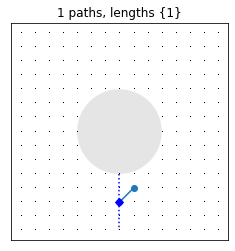

In [4]:
path = [start, Point(1, -4)]
plot([path])

Here are nine paths for the second move (two of which crash into the circle in the center):

In [5]:
def velocity(path) -> Vector:
    """Velocity of the car at the end of the path."""
    return zero if len(path) == 1 else path[-1] - path[-2]  

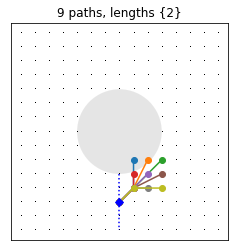

In [6]:
plot([path + [Point(path[-1] + velocity(path) + d)] for d in deltas])

# Complete Paths and Legal Moves

For our circle-in-the-middle track, I can say that a path `is_complete` if the path goes from the fourth quadrant to the first, second, third, and back to the fourth:

In [7]:
def Q1(p) -> bool: return X(p) >= 0 and Y(p) >= 0 # upper right
def Q2(p) -> bool: return X(p) <  0 and Y(p) >= 0 # upper left
def Q3(p) -> bool: return X(p) <  0 and Y(p) <  0 # lower left  
def Q4(p) -> bool: return X(p) >= 0 and Y(p) <  0 # lower right
   
def is_complete(path, regions=(Q4, Q1, Q2, Q3, Q4)) -> bool:
    """Does the path complete a tour of the regions, in order?"""
    for p in path:
        if regions[0](p):
            regions = regions[1:]
    return not regions

Now I'll define the `legal_moves` that can be made. Given a path, `legal_moves(path)` yields all points that can follow on to the end of the path. Each point must be a point on the track (not inside the circle), the velocity vector can differ from the previous velocity vector only by an allowable delta, and the line from the previous final point on the path to the new point must not intersect the circle. 

I have inserted a hack here: to make sure that paths start off going counterclockwise, for the first two steps I insist that the deltas be either up or to the right or zero.

I got the calculation for `intersects_circle` from several posts on math overflow.

In [8]:
def legal_moves(path, track=track, deltas=deltas) -> Iterator[Point]:
    """What points can be reached in one step from this path?"""
    if len(path) <= 2: # Make sure we start counterclockwwise
        deltas = [Point(x, y) for y in (0, 1) for x in (0, 1)]
    p, v = path[-1], velocity(path)
    for d in deltas:
        new_p = p + v + d
        if new_p in track and not intersects_circle(p, new_p, 3, zero):
            yield new_p
            
def intersects_circle(p, q, r, c):
    """Does a line from p to q intersect a circle of radius r at center c?"""
    if p == q:
        return abs(c - p) < r
    norm = (q - p) / abs(q - p)
    v  = abs(X(norm) * Y(c - p) - Y(norm) * X(c - p)) # Norm of the 2D cross-product
    return (v < r)

# Finding a Fastest Path

I can use a breadth-first search, adding each legal move to each path until I find path(s) that are complete. 

I keep track of a `frontier`, which is a mapping of `{(point, velocity): path}` for all paths of the longest length explored so far. The reason for this is that there may be an exponential number of paths that arrive at the some position with the same velocity in the same number of moves. But none of them will have any advantage in reaching the finish line ahead of the others, so I only need to keep one of them. In the end, I return the completed paths I have found, but there may be many other paths that are not returned, because I only kept one for each `(point, velocity)` pair along the way. 

In [9]:
def search(path=[start]) -> Path:
    """Find the shortest possible complete path(s)."""
    frontier = {(path[-1], velocity(path)): path}
    completed = []
    while not completed:
        frontier  = expand(frontier)
        completed = [path for path in frontier.values() if is_complete(path)]
    return completed

def expand(frontier) -> dict:
    """The {(point, velocity): path} mapping extended one step in all legal ways."""
    return {(p, velocity(path + [p])): path + [p] 
            for path in frontier.values() 
            for p in legal_moves(path)}

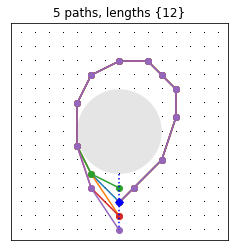

In [10]:
plot(search([start]))

# Submitting your Answer

I'll need some help to put my answers into the form requested by The Riddler:

> Finally, submitting your answer can be tricky work. Please be sure to submit both your total time, as well as your sequence of moves. Each move should be assigned a digit from 1 through 9, corresponding to the nine possible destinations of the move:
>
>     1 2 3
>     4 5 6
>     7 8 9

In [11]:
def encode_path(path) -> List[int]:
    """The digits representing the moves (as coded changes in acceleration)."""
    return [deltas.index(velocity(path[:i + 1]) - velocity(path[:i])) + 1
            for i in range(1, len(path))]

def decode_path(digits, start=start) -> Path:
    """The points that the digits represent."""
    velocity = zero
    path = [start]
    for d in digits:
        velocity += deltas[d - 1]
        path.append(velocity + path[-1])
    return path

In [12]:
for path in search():
    print(encode_path(path))
    assert path == decode_path(encode_path(path)) 

[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 6]
[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 9]
[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 3]
[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 3]
[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 6]


To get an idea of some of the paths that were discarded by the `frontier`, here we start with a path that is tighter around the circle, and search for completions:

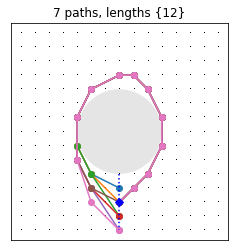

In [13]:
plot(search(decode_path([3, 5, 2, 4, 4])))